In [ ]:
# -----------------------------
# Imports
# -----------------------------
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yfinance as yf


In [ ]:
# -----------------------------
# Utilities
# -----------------------------
def year_fraction(start: datetime, end: datetime) -> float:
    """Simple ACT/365 year fraction."""
    return (end - start).days / 365.0


In [ ]:
# -----------------------------
# Term structure (yield curve) helper
# -----------------------------
class YieldCurve:
    """
    Term structure object that accepts either a flat rate or a set of (tenor_years -> rate) points.
    Interpolates linearly in year space.
    Rates assumed continuous compounding.
    """
    def __init__(self, points: Optional[Dict[float, float]] = None, flat_rate: Optional[float] = None):
        if flat_rate is None and (points is None or len(points) == 0):
            raise ValueError("Either flat_rate or points must be provided")
        if flat_rate is not None:
            self.flat = True
            self.r = float(flat_rate)
            self._interp = None
        else:
            self.flat = False
            xs = np.array(sorted(points.keys()))
            ys = np.array([points[x] for x in xs])
            self._interp = interp1d(xs, ys, kind='linear', fill_value='extrapolate')

    def rate(self, t: float) -> float:
        if self.flat:
            return self.r
        return float(self._interp(t))

    def discount_factor(self, t: float) -> float:
        r = self.rate(t)
        return math.exp(-r * t)


In [ ]:
# -----------------------------
# Bond representation
# -----------------------------
@dataclass
class Bond:
    name: str
    face: float
    coupon_rate: float
    maturity_date: datetime
    coupon_freq: int = 2
    issue_date: Optional[datetime] = None
    is_zero: bool = False

    def cashflows(self, as_of: datetime) -> List[Tuple[datetime, float]]:
        if self.is_zero:
            return [(self.maturity_date, self.face)] if self.maturity_date > as_of else []

        payments = []
        period_months = 12 // self.coupon_freq
        payment_dates = []
        cur = self.maturity_date
        while cur > as_of:
            payment_dates.append(cur)
            cur -= timedelta(days=period_months*30)  # approx
            if len(payment_dates) > 1000:
                break
        payment_dates = sorted(payment_dates)

        coupon_amount = self.face * self.coupon_rate / self.coupon_freq
        for d in payment_dates[:-1]:
            payments.append((d, coupon_amount))
        if payment_dates:
            payments.append((payment_dates[-1], coupon_amount + self.face))
        return payments

    def clean_price(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv += amt * df
        return pv

    def macaulay_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv, weighted_sum = 0.0, 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv_cf = amt * df
            pv += pv_cf
            weighted_sum += t * pv_cf
        return weighted_sum / pv if pv else 0.0

    def modified_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        mac_dur = self.macaulay_duration(as_of, ytm, curve)
        y = ytm if ytm is not None else curve.rate(year_fraction(as_of, self.maturity_date))
        return mac_dur / (1 + y)

    def convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv, conv = 0.0, 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv_cf = amt * df
            pv += pv_cf
            conv += t * (t + 1) * pv_cf
        return conv / pv if pv else 0.0

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base_price = self.clean_price(as_of, ytm, curve)
        if curve:
            if curve.flat:
                bumped_curve = YieldCurve(flat_rate=curve.r + bump)
            else:
                class ShiftedCurve:
                    def __init__(self, base_curve, shift): self.base_curve, self.shift, self.flat = base_curve, shift, False
                    def rate(self, t): return self.base_curve.rate(t) + self.shift
                    def discount_factor(self, t): return math.exp(-self.rate(t) * t)
                bumped_curve = ShiftedCurve(curve, bump)
            bumped_price = self.clean_price(as_of, curve=bumped_curve)
        else:
            bumped_price = self.clean_price(as_of, ytm=ytm + bump)
        return bumped_price - base_price


In [ ]:
# -----------------------------
# Portfolio container
# -----------------------------
@dataclass
class Portfolio:
    bonds: List[Tuple[Bond, float]] = field(default_factory=list)  # (Bond, notional)

    def market_value(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        total_mv = 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm=ytm, curve=curve)
            total_mv += price * (notional / bond.face)
        return total_mv

    def aggregate_duration_convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> Dict[str, float]:
        mv = self.market_value(as_of, ytm, curve)
        dur_sum, conv_sum = 0.0, 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm, curve)
            pos_mv = price * (notional / bond.face)
            dur_sum += bond.modified_duration(as_of, ytm, curve) * pos_mv
            conv_sum += bond.convexity(as_of, ytm, curve) * pos_mv
        return {"duration": dur_sum / mv if mv else 0.0, "convexity": conv_sum / mv if mv else 0.0}

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base_mv = self.market_value(as_of, ytm, curve)
        if curve:
            if curve.flat:
                bumped_curve = YieldCurve(flat_rate=curve.r + bump)
            else:
                class ShiftedCurve:
                    def __init__(self, base_curve, shift): self.base_curve, self.shift, self.flat = base_curve, shift, False
                    def rate(self, t): return self.base_curve.rate(t) + self.shift
                    def discount_factor(self, t): return math.exp(-self.rate(t) * t)
                bumped_curve = ShiftedCurve(curve, bump)
            bumped_mv = self.market_value(as_of, curve=bumped_curve)
        else:
            bumped_mv = self.market_value(as_of, ytm=ytm + bump)
        return bumped_mv - base_mv


In [ ]:
# -----------------------------
# Scenario engine
# -----------------------------
class ScenarioEngine:
    def __init__(self, base_curve: YieldCurve, as_of: datetime):
        self.base_curve = base_curve
        self.as_of = as_of

    def parallel_shift(self, portfolio: Portfolio, shift_bp: float) -> Dict:
        shift = shift_bp / 10000.0
        if self.base_curve.flat:
            bumped_curve = YieldCurve(flat_rate=self.base_curve.r + shift)
        else:
            class ShiftedCurve:
                def __init__(self, base_curve, shift): self.base_curve, self.shift, self.flat = base_curve, shift, False
                def rate(self, t): return self.base_curve.rate(t) + self.shift
                def discount_factor(self, t): return math.exp(-self.rate(t) * t)
            bumped_curve = ShiftedCurve(self.base_curve, shift)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        bumped_mv = portfolio.market_value(self.as_of, curve=bumped_curve)
        return {
            "scenario": f"parallel_{shift_bp}bp",
            "base_mv": base_mv,
            "bumped_mv": bumped_mv,
            "pv_change": bumped_mv - base_mv,
            "pv_change_pct": (bumped_mv - base_mv) / base_mv if base_mv else 0.0
        }

    def steepen_flatten(self, portfolio: Portfolio, short_shift_bp: float, long_shift_bp: float, pivot_year: float = 2.0) -> Dict:
        s_shift, l_shift = short_shift_bp / 10000.0, long_shift_bp / 10000.0

        class TwistedCurve:
            def __init__(self, base_curve, s_shift, l_shift, pivot):
                self.base_curve, self.s_shift, self.l_shift, self.pivot, self.flat = base_curve, s_shift, l_shift, pivot, False
            def rate(self, t):
                if t <= 0: return self.base_curve.rate(0)
                factor = min(1.0, t / self.pivot)
                return self.base_curve.rate(t) + (1 - factor) * self.s_shift + factor * self.l_shift
            def discount_factor(self, t): return math.exp(-self.rate(t) * t)

        twisted_curve = TwistedCurve(self.base_curve, s_shift, l_shift, pivot_year)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        twisted_mv = portfolio.market_value(self.as_of, curve=twisted_curve)
        return {
            "scenario": f"twist_short{short_shift_bp}bp_long{long_shift_bp}bp",
            "base_mv": base_mv,
            "twisted_mv": twisted_mv,
            "pv_change": twisted_mv - base_mv,
            "pv_change_pct": (twisted_mv - base_mv) / base_mv if base_mv else 0.0
        }


In [ ]:
# -----------------------------
# Vasicek short-rate model for Monte Carlo simulation
# -----------------------------
class VasicekSimulator:
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float, dt: float = 1/252):
        self.r0, self.kappa, self.theta, self.sigma, self.dt = r0, kappa, theta, sigma, dt

    def simulate_paths(self, n_paths: int, n_steps: int) -> np.ndarray:
        paths = np.zeros((n_paths, n_steps + 1))
        paths[:, 0] = self.r0
        for t in range(1, n_steps + 1):
            z = np.random.normal(size=n_paths)
            dr = self.kappa * (self.theta - paths[:, t-1]) * self.dt + self.sigma * np.sqrt(self.dt) * z
            paths[:, t] = paths[:, t-1] + dr
        return paths


In [ ]:
# -----------------------------
# Get Treasury yield curve from yfinance
# -----------------------------
def get_yfinance_treasury_yield_curve() -> Dict[float, float]:
    tickers = {
        0.25: '^IRX',   # 3 months
        5.0: '^FVX',    # 5 years
        10.0: '^TNX',   # 10 years
        30.0: '^TYX'    # 30 years
    }
    points = {}
    for years, ticker in tickers.items():
        data = yf.Ticker(ticker).history(period='5d')
        if data.empty:
            continue
        latest_rate = data['Close'][-1] / 100  # % to decimal
        cc_rate = np.log(1 + latest_rate)      # continuous compounding
        points[years] = cc_rate

    # Approximate 2Y by interpolation
    if 0.25 in points and 5.0 in points:
        points[2.0] = points[0.25] + (points[5.0] - points[0.25]) * (2.0 - 0.25) / (5.0 - 0.25)

    print("Using Treasury yield curve points from yfinance:", points)
    return points


/tmp/ipython-input-2688107393.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # % to decimal
/tmp/ipython-input-2688107393.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # % to decimal
/tmp/ipython-input-2688107393.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # % to decimal
/tmp/ipython-input-268810

Using Treasury yield curve points from yfinance: {0.25: np.float64(0.040421914498915405), 5.0: np.float64(0.0372090747164157), 10.0: np.float64(0.04162167469081945), 30.0: np.float64(0.04715072644135329), 2.0: np.float64(0.03923823668431025)}
Base Market Value: 16,935,716.01
Aggregate Duration: 4.5797
Aggregate Convexity: 30.5915
Portfolio DV01: -8,048.64

Scenario Results:
                   scenario       base_mv     bumped_mv      pv_change  \
0            parallel_50bp  1.693572e+07  1.653859e+07 -397123.994585   
1           parallel_-50bp  1.693572e+07  1.734378e+07  408064.296034   
2  twist_short0bp_long50bp  1.693572e+07           NaN -395455.731045   

   pv_change_pct    twisted_mv  
0      -0.023449           NaN  
1       0.024095           NaN  
2      -0.023350  1.654026e+07  

Saved scenario_results.csv
Saved pv_changes.png

Monte Carlo Simulation Results (Vasicek Model):
Mean Portfolio MV: 17,555,899.34
Std Dev Portfolio MV: 796,979.74
Saved mc_portfolio_mv_histogram.p

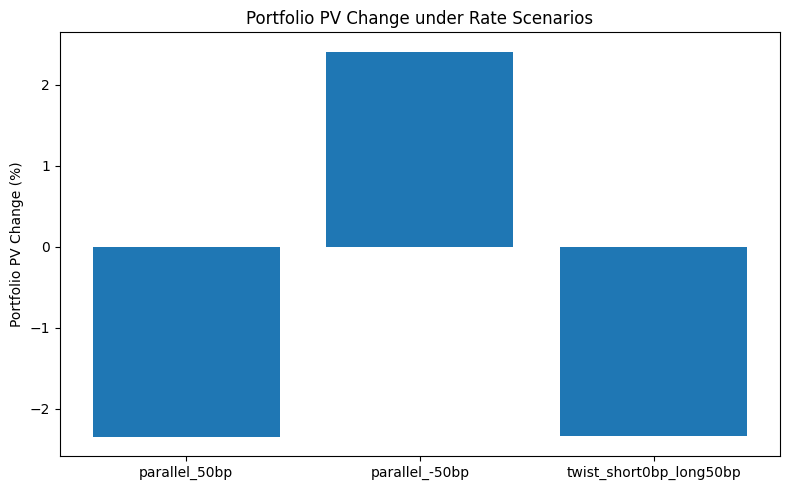

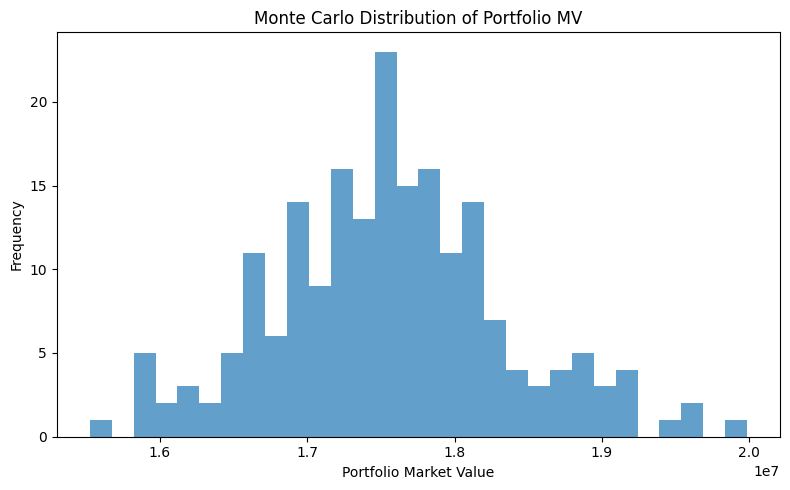

In [ ]:
# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    today = datetime.today()

    # Yield curve from yfinance
    points = get_yfinance_treasury_yield_curve()
    base_curve = YieldCurve(points=points)

    # Sample bonds
    b1 = Bond('UST_5Y', 1000, 0.03, today + timedelta(days=5*365), coupon_freq=2, issue_date=today - timedelta(days=30))
    b2 = Bond('CORP_7Y', 1000, 0.045, today + timedelta(days=7*365), coupon_freq=2, issue_date=today - timedelta(days=30))
    b3 = Bond('ZERO_2Y', 1000, 0.0, today + timedelta(days=2*365), coupon_freq=1, is_zero=True)

    portfolio = Portfolio([(b1, 10_000_000), (b2, 5_000_000), (b3, 2_000_000)])

    # Base analytics
    base_mv = portfolio.market_value(today, curve=base_curve)
    agg = portfolio.aggregate_duration_convexity(today, curve=base_curve)
    dv01 = portfolio.dv01(today, curve=base_curve)

    print(f"Base Market Value: {base_mv:,.2f}")
    print(f"Aggregate Duration: {agg['duration']:.4f}")
    print(f"Aggregate Convexity: {agg['convexity']:.4f}")
    print(f"Portfolio DV01: {dv01:,.2f}")

    # Scenario analysis
    scenario_engine = ScenarioEngine(base_curve, today)
    scenarios = [
        scenario_engine.parallel_shift(portfolio, 50),
        scenario_engine.parallel_shift(portfolio, -50),
        scenario_engine.steepen_flatten(portfolio, 0, 50)
    ]
    df_scenarios = pd.DataFrame(scenarios)
    print("\nScenario Results:\n", df_scenarios)

    df_scenarios.to_csv('scenario_results.csv', index=False)
    print("\nSaved scenario_results.csv")

    # Plot PV changes %
    plt.figure(figsize=(8,5))
    plt.bar(df_scenarios['scenario'], df_scenarios['pv_change_pct'] * 100)
    plt.ylabel('Portfolio PV Change (%)')
    plt.title('Portfolio PV Change under Rate Scenarios')
    plt.tight_layout()
    plt.savefig('pv_changes.png')
    print("Saved pv_changes.png")

    # Vasicek Monte Carlo
    vasicek = VasicekSimulator(r0=0.03, kappa=0.15, theta=0.035, sigma=0.01)
    paths = vasicek.simulate_paths(n_paths=200, n_steps=252)

    mc_values = []
    for r_sim in paths[:, -1]:
        sim_curve = YieldCurve(flat_rate=float(r_sim))
        mc_values.append(portfolio.market_value(today, curve=sim_curve))

    mc_values = np.array(mc_values)
    print("\nMonte Carlo Simulation Results (Vasicek Model):")
    print(f"Mean Portfolio MV: {mc_values.mean():,.2f}")
    print(f"Std Dev Portfolio MV: {mc_values.std():,.2f}")

    plt.figure(figsize=(8,5))
    plt.hist(mc_values, bins=30, alpha=0.7)
    plt.xlabel('Portfolio Market Value')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Distribution of Portfolio MV')
    plt.tight_layout()
    plt.savefig('mc_portfolio_mv_histogram.png')
    print("Saved mc_portfolio_mv_histogram.png")


===== VaR & Expected Shortfall (95%) =====
Base Market Value         : 16,935,716.01
95% VaR (absolute)        : 774,392.96
95% VaR (percent)         : 4.5725%
95% Expected Shortfall    : 999,192.91
95% ES (percent)          : 5.8999%
Saved mc_var_es_results.csv


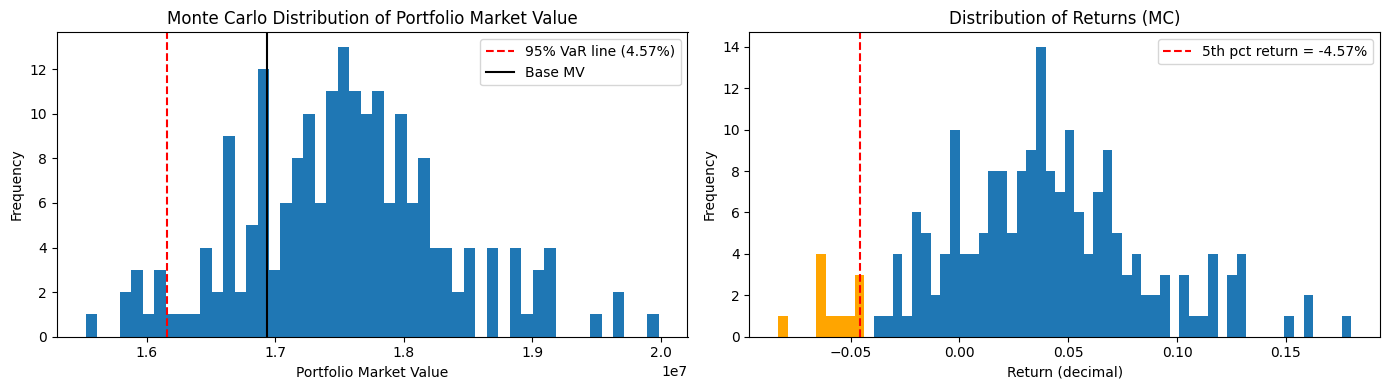


Tail summary (worst 5%):
 - 5th percentile return        : -4.5725%
 - Mean return (worst 5%)      : -5.8999%
 - Number of sims in worst 5%  : 10
Saved mc_var_es_plots.png


In [ ]:
# -----------------------------
# Cell 10 — Compute 95% VaR and 95% ES from MC results (or recompute MC if needed)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# --- Helper: ensure we have base market value and mc_values (portfolio MV under MC) ---
def ensure_mc_values(recompute_if_missing=True, mc_paths=200, mc_steps=252):
    global mc_values  # will set mc_values in globals if computed here
    try:
        # prefer mc_values if already present (created in Cell 9 as 'mc_values' or 'mc_vals')
        if 'mc_values' in globals():
            return mc_values
        if 'mc_vals' in globals():
            mc_values = mc_vals
            return mc_values
        # fallback: recompute using VasicekSimulator if allowed
        if not recompute_if_missing:
            raise NameError("mc_values not found and recompute_if_missing is False")
        print("mc_values not found — running a quick Vasicek MC to generate mc_values...")
        vas = VasicekSimulator(r0=0.03, kappa=0.15, theta=0.035, sigma=0.01, dt=1/252)
        paths_local = vas.simulate_paths(n_paths=mc_paths, n_steps=mc_steps)
        mc_vals_local = []
        for r_sim in paths_local[:, -1]:
            sim_curve = YieldCurve(flat_rate=float(r_sim))
            mv_sim = portfolio.market_value(scenario_engine.as_of if 'scenario_engine' in globals() else datetime.today(), curve=sim_curve)
            mc_vals_local.append(mv_sim)
        mc_values = np.array(mc_vals_local)
        return mc_values
    except Exception as e:
        raise RuntimeError("Could not obtain or compute mc_values. Make sure Cells 1-9 executed.") from e

# Get base market value (use available 'base_mv' if present)
if 'base_mv' in globals():
    base_mv_val = base_mv
else:
    # attempt to compute from available objects
    try:
        base_mv_val = portfolio.market_value(scenario_engine.as_of if 'scenario_engine' in globals() else datetime.today(), curve=base_curve)
    except Exception as e:
        raise RuntimeError("Unable to compute base market value. Ensure 'portfolio' and 'base_curve' exist and earlier cells ran.") from e

# Ensure mc_values
mc_values = ensure_mc_values(recompute_if_missing=True, mc_paths=2000, mc_steps=252)  # default 2k sims for better tails

# Compute P&L and returns
pnl = mc_values - base_mv_val                  # positive = gain, negative = loss
returns = pnl / base_mv_val                    # relative returns

# For VaR/ES we treat losses as positive numbers:
losses = -pnl                                   # loss = base - simulated (positive if simulated < base)

# 95% VaR: loss threshold exceeded with prob 5% -> 95th percentile of loss distribution
var95_abs = np.percentile(losses, 95)           # absolute currency VaR (positive number)
var95_pct = var95_abs / base_mv_val             # percent VaR (positive number)

# 95% Expected Shortfall (average loss in worst 5%)
worst_5pct_mask = losses >= np.percentile(losses, 95)
if worst_5pct_mask.sum() == 0:
    es95_abs = var95_abs
else:
    es95_abs = losses[worst_5pct_mask].mean()
es95_pct = es95_abs / base_mv_val

# Print nicely
print("===== VaR & Expected Shortfall (95%) =====")
print(f"Base Market Value         : {base_mv_val:,.2f}")
print(f"95% VaR (absolute)        : {var95_abs:,.2f}")
print(f"95% VaR (percent)         : {var95_pct*100:.4f}%")
print(f"95% Expected Shortfall    : {es95_abs:,.2f}")
print(f"95% ES (percent)          : {es95_pct*100:.4f}%")
print("==========================================")

# Save results to CSV for reporting
results_df = pd.DataFrame({
    "base_mv": [base_mv_val],
    "var95_abs": [var95_abs],
    "var95_pct": [var95_pct],
    "es95_abs": [es95_abs],
    "es95_pct": [es95_pct],
    "mc_sim_count": [len(mc_values)]
})
results_df.to_csv("mc_var_es_results.csv", index=False)
print("Saved mc_var_es_results.csv")

# --- Plots: left = MC distribution with VaR line; right = return distribution with worst-5% shaded ---
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Left: distribution of simulated portfolio values
axes[0].hist(mc_values, bins=50)
axes[0].axvline(base_mv_val - var95_abs, color='red', linestyle='--', label=f"95% VaR line ({(var95_pct*100):.2f}%)")
axes[0].axvline(base_mv_val, color='black', linestyle='-', label="Base MV")
axes[0].set_title("Monte Carlo Distribution of Portfolio Market Value")
axes[0].set_xlabel("Portfolio Market Value")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Right: distribution of returns, shade worst 5%
n, bins, patches = axes[1].hist(returns, bins=60)
axes[1].set_title("Distribution of Returns (MC)")
axes[1].set_xlabel("Return (decimal)")
axes[1].set_ylabel("Frequency")

# Shade bars corresponding to worst 5%
threshold_return = np.percentile(returns, 5)  # 5th percentile of returns
for patch, b_left in zip(patches, bins[:-1]):
    if b_left <= threshold_return:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor('C0')
axes[1].axvline(threshold_return, color='red', linestyle='--', label=f"5th pct return = {threshold_return*100:.2f}%")
axes[1].legend()

plt.tight_layout()
plt.show()

# (Optional) Print a short summary of tail stats
print("\nTail summary (worst 5%):")
print(f" - 5th percentile return        : {threshold_return*100:.4f}%")
print(f" - Mean return (worst 5%)      : {returns[returns <= threshold_return].mean()*100:.4f}%")
print(f" - Number of sims in worst 5%  : {max(1, int(len(returns) * 0.05))}")

# Save histogram figure
fig.savefig("mc_var_es_plots.png", bbox_inches='tight')
print("Saved mc_var_es_plots.png")


Final short-rate stats:
 mean: 0.030706, std: 0.009474, min: 0.003587, max: 0.056409
 initial r0: 0.030000
Pearson corr(final_rate, portfolio_MV) = -0.999 (p=1.778e-282)


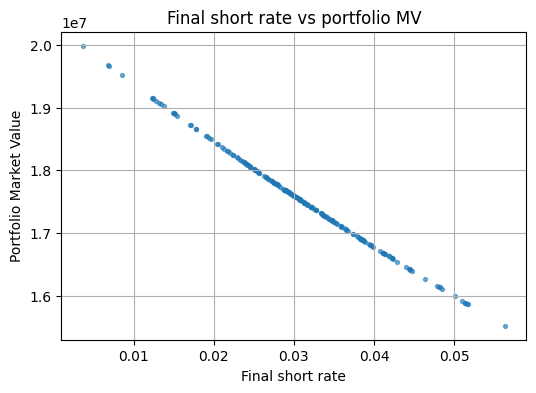

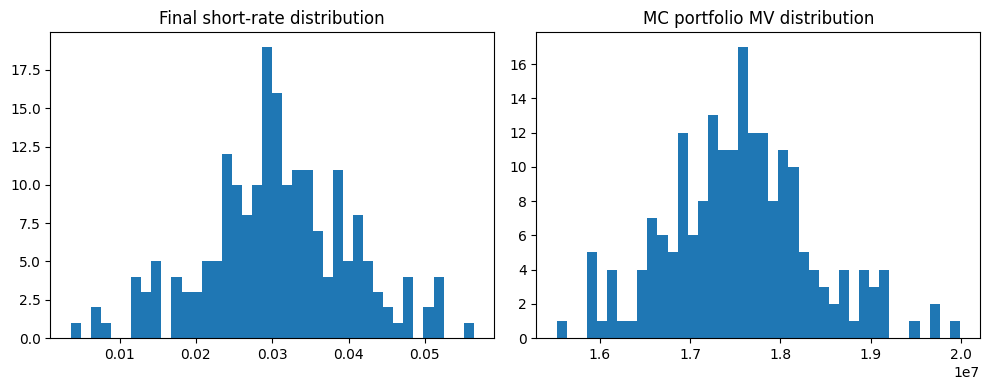

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# assume `paths` is your Vasicek paths array shape (n_paths, n_steps+1)
# and `mc_values` (or mc_values) are simulated portfolio MVs using final short rate

final_rates = paths[:, -1]              # shape (n_paths,)
print("Final short-rate stats:")
print(f" mean: {final_rates.mean():.6f}, std: {final_rates.std():.6f}, min: {final_rates.min():.6f}, max: {final_rates.max():.6f}")
print(f" initial r0: {paths[:,0][0]:.6f}")

# correlation with portfolio value
if 'mc_values' in globals():
    corr, p = pearsonr(final_rates, mc_values)
    print(f"Pearson corr(final_rate, portfolio_MV) = {corr:.3f} (p={p:.3e})")
    plt.figure(figsize=(6,4))
    plt.scatter(final_rates, mc_values, s=8, alpha=0.6)
    plt.xlabel('Final short rate')
    plt.ylabel('Portfolio Market Value')
    plt.title('Final short rate vs portfolio MV')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(final_rates, bins=40)
plt.title('Final short-rate distribution')
plt.subplot(1,2,2)
plt.hist(mc_values, bins=40)
plt.title('MC portfolio MV distribution')
plt.tight_layout()
plt.show()
